In [1]:
#ライブラリ
from crabnet.crabnet_ import get_data
from crabnet.data.materials_data import elasticity
from crabnet.crabnet_ import CrabNet
from os.path import join
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from crabnet.utils.data import get_data
from crabnet.crabnet_ import CrabNet
import vickers_hardness.data as vh_data
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    ShuffleSplit,
)
from vickers_hardness.utils.plotting import parity_with_err
from vickers_hardness.vickers_hardness_ import VickersHardness

/workspaces/mat2vec_codespace/.venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#テストモデルでのデータ数は1000程度であったので今回のデータもいったん1000にしてやる

In [7]:
X = pd.read_csv("/workspaces/mat2vec_codespace/main_code/final_SC_X_data.csv")

X = X.sample(frac=1, random_state=42).reset_index(drop=True)

X = X.iloc[:1000]

y = X["Tc"]
X = X.drop(columns=["Tc"])

In [9]:
# %% K-fold cross-validation
ss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
cv = GroupKFold()
cvtype = "gcv"

groups = X["formula"]


trainval_idx, test_idx = list(ss.split(X, y, groups=groups))[0]

In [10]:
X_test, y_test = X.iloc[test_idx, :], y[test_idx]
X, y = X.iloc[trainval_idx, :], y.iloc[trainval_idx]

subgroups = X["formula"]

crabnet_dfs = []

In [11]:
for train_index, test_index in cv.split(X, y, subgroups):#上記のcvをしたそれぞれのデータセットのペアごとに処理を実行
    X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    train_df = pd.DataFrame(
        {"formula": X_train["formula"], "target": y_train}
    )
    val_df = pd.DataFrame(
        {"formula": X_val["formula"], "target": y_val}
    )
    
    display(train_df)
    display(val_df)
    
    cb = CrabNet(#ここでCrabNetのモデルを作成 学習時に表示されている学習曲線の表示や学習時のbatch数などについてはここで設定を行う
                #今回のモデルだとデフォルトのbatch数は128
        model_name = "SC_model_1st",
        verbose=True,
        random_state = 42,
        learningcurve=True,
        losscurve = True,
    )
    
    break

,formula,target
0,Lu0.945Gd0.055Ni2B2C1,13.28
1,Ba0.6K0.4Fe2As2,36.80
3,Sr1Fe1.6Co0.4As2,12.90
4,Be13U0.9645Th0.0355,0.55
5,Eu1Rb1Fe4As4,36.78
...,...,...
993,Pr0.91La1Ce0.09Cu1O4,24.00
994,Sn1Mo6S8,11.70
995,Nb3Rh0.9Pd0.1,2.55
998,La1.85Sr0.15Cu1O4,36.50


,formula,target
2,Ge1.85La1,2.17
13,Dy0.9Ca0.1Ba2Cu2.7Zn0.3O6.72,21.00
18,Cs2Cr3As3,1.85
25,La1.8Sr0.2Cu1O4,34.20
27,Sn1As0.87Se0.13,4.40
...,...,...
972,Nb2S1C0.85,4.68
974,Tm1Ni2B2C1,10.90
978,Tl0.5Pb0.5Sr4Cu2C1O10,71.00
990,In1,3.14



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 570/570 [00:00<00:00, 113413.34formulae/s]


skipping composition OrderedDict([('Fe', 2.0), ('Se', 2.0), ('Li', 1.0), ('M', 1.0)])
skipping composition OrderedDict([('S', 2.0), ('M', 1.0), ('Ta', 1.0)])
skipping composition OrderedDict([('S', 2.0), ('Mo', 1.0), ('Ca', 0.35), ('M', 0.33)])
skipping composition OrderedDict([('S', 2.0), ('M', 1.0), ('Ta', 1.0)])
skipping composition OrderedDict([('Se', 2.0), ('M', 1.0), ('Ti', 1.0), ('Li', 0.2)])
skipping composition OrderedDict([('S', 2.0), ('M', 1.0), ('Ta', 1.0)])
skipping composition OrderedDict([('S', 2.0), ('Mo', 1.0), ('M', 0.41), ('Ca', 0.4)])
skipping composition OrderedDict([('Fe', 1.86), ('Se', 1.8), ('Na', 0.8), ('M', 0.6), ('S', 0.2)])
skipping composition OrderedDict([('S', 2.0), ('M', 1.0), ('Nb', 1.0)])
skipping composition OrderedDict([('Nb', 0.982), ('D', 0.018)])
skipping composition OrderedDict([('M', 1.0), ('Se', 1.0), ('Fe', 0.995), ('Li', 0.6), ('V', 0.005)])
skipping composition OrderedDict([('S', 2.0), ('M', 1.0), ('Ta', 1.0)])
loading data with up to 7 elem

Generating EDM: 100%|██████████| 143/143 [00:00<00:00, 96242.85formulae/s]

skipping composition OrderedDict([('Se', 2.0), ('M', 1.0), ('Ti', 1.0), ('Li', 0.15)])
skipping composition OrderedDict([('Fe', 2.0), ('Te', 1.2), ('Se', 0.8), ('Na', 0.45), ('M', 0.3)])
skipping composition OrderedDict([('Fe', 2.0), ('Se', 2.0), ('M', 1.0), ('Li', 0.6)])
skipping composition OrderedDict([('S', 2.0), ('M', 1.0), ('Ta', 1.0)])
skipping composition OrderedDict([('Os', 2.0), ('Ls', 0.91), ('Gd', 0.09)])
loading data with up to 7 elements in the formula
stepping every 50 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler



NaN values found in `pred_t`. Replacing with DummyRegressor() values (i.e. mean of training targets).
NaN values found in `pred_v`. Replacing with DummyRegressor() values (i.e. mean of training targets) using `np.nanmean`.


Epoch: 0/300 --- train mae: 21.5 val mae: 20.5


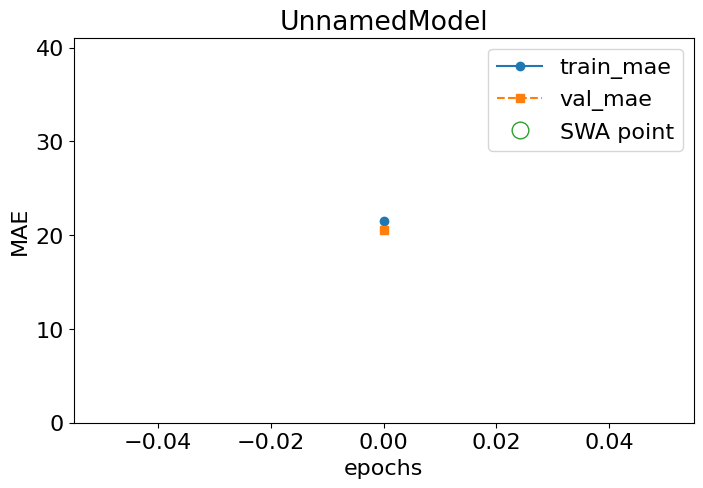

NaN values found in `pred_v`. Replacing with DummyRegressor() values (i.e. mean of training targets)
NaN values found in `pred_v`. Replacing with DummyRegressor() values (i.e. mean of training targets)
NaN values found in `pred_v`. Replacing with DummyRegressor() values (i.e. mean of training targets)
NaN values found in `pred_v`. Replacing with DummyRegressor() values (i.e. mean of training targets)
NaN values found in `pred_v`. Replacing with DummyRegressor() values (i.e. mean of training targets)
NaN values found in `pred_t`. Replacing with DummyRegressor() values (i.e. mean of training targets).
NaN values found in `pred_v`. Replacing with DummyRegressor() values (i.e. mean of training targets) using `np.nanmean`.


Epoch: 19/300 --- train mae: 21.5 val mae: 20.5


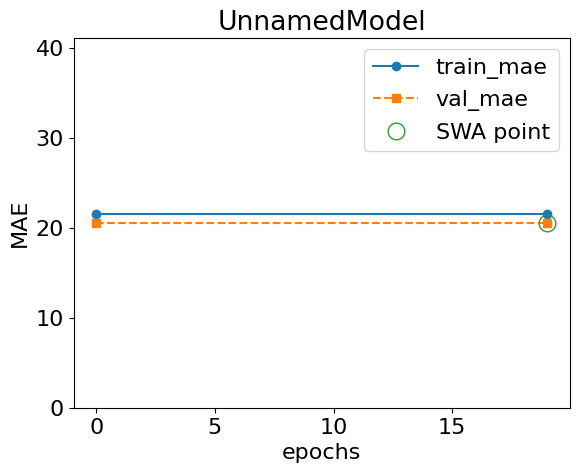

KeyboardInterrupt: 

In [12]:

cb.fit(train_df)#モデル訓練

y_pred, y_std, y_true,  = cb.predict(test_df = val_df, return_uncertainty = True, return_true = True)#原文ママではエラー　原因は出力が4つも出てこないということ、実際オプションでy_trueおよびy_stdを追加することは可能
#ただし、何もオプションを入れていない時点では、予測された結果値のみが出力される
#得られるstdは予測された値の標準偏差を示している
crabnet_dfs.append(#答えのファイルの作成
    pd.DataFrame(
        {
            "actual_Tc": y_true,
            "predicted_Tc": y_pred,
            "y_std": y_std,
            "formula": val_df["formula"],
        }
    )
)